In [1]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from mpl_toolkits import mplot3d
import time
from klepto.archives import dir_archive

In [2]:
from rawFLIR_polarization_data_extraction import *
from slope2height import *

In [3]:
NUM_IMAGES=1
BEDFORM = 'dunes'
TEST = 2
SUBFOLDER = 4
file_location = "../FLIR_Camera/"+BEDFORM+"_fastFlow_ShallowH_test"+str(TEST)+"_centeredCam_flume_LookAngle_35Deg"
ref_image_name = 'reference.tiff'
figures_location = "../FLIR_Camera/"+BEDFORM+"_fastFlow_ShallowH_test"+str(TEST)+"_centeredCam_flume_LookAngle_35Deg_FIGURES"
height_figs_location  = "../FLIR_Camera/"+BEDFORM+"_fastFlow_ShallowH_test"+str(TEST)+"_centeredCam_flume_LookAngle_35Deg_HEIGHT_FIGURES"
save_location =  "../FLIR_Camera"
data_foldername = BEDFORM + "_fastFlow_ShallowH_test" + str(TEST) +"_subFolder" + str(SUBFOLDER)
dark_files_location = "../FLIR_Camera/dark_imgs"
flat_files_location = "../FLIR_Camera/flat_imgs"

In [4]:
filenames = os.listdir(file_location)
filenames.remove(ref_image_name) 

In [5]:
print(len(filenames))
filenames = filenames[3*len(filenames)//4:len(filenames)]

901


In [6]:
flat_field_correction_params = flat_field_params(dark_files_location, flat_files_location)

In [7]:
im_theta1, im_phi1 = theta_phi(ref_image_name, file_location,
                               material = 'water',
                               flat_field_correct = 1,
                               gaussian_smoothing_sigma = 0,
                               num_images= NUM_IMAGES, correction_angle=0,
                               flat_field_correction_params = flat_field_correction_params)

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03298044204711914 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.05196976661682129 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:225: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:226: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.723528146743774 seconds
False
AoLP time:  0.040975332260131836 s


In [8]:
for filename2 in tqdm(filenames[0:1]): #
    im_theta2, im_phi2 = theta_phi(filename2, file_location,
                               material = 'water',
                               flat_field_correct = 1,
                               gaussian_smoothing_sigma = 0,
                               num_images= NUM_IMAGES, correction_angle=0,
                               flat_field_correction_params = flat_field_correction_params)

    raw_img2 = cv2.imread(os.path.join(file_location, filename2))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03397965431213379 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.046972036361694336 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.680015563964844 seconds
False
AoLP time:  0.046973228454589844 s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.01s/it]


<Figure size 432x288 with 0 Axes>

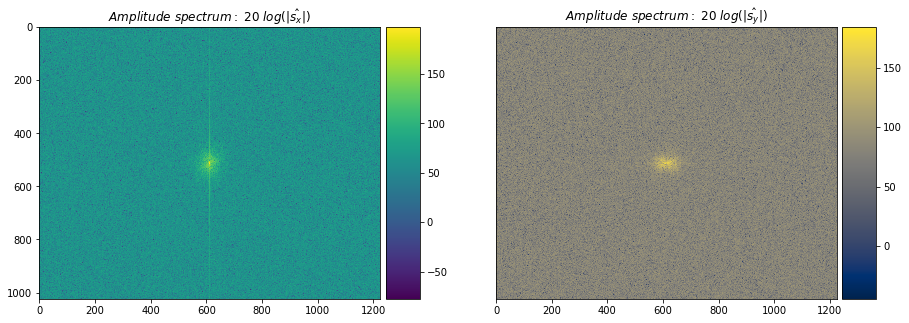

<Figure size 432x288 with 0 Axes>

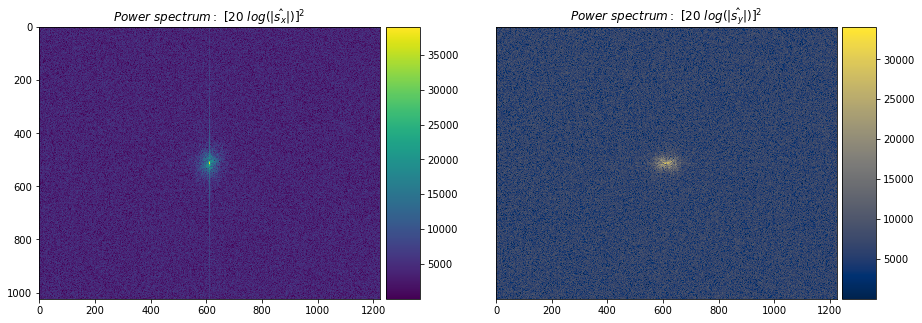

In [9]:
s_x = np.tan(np.radians((im_theta2 - im_theta1)))
s_y = np.tan(np.radians((im_phi2 - im_phi1)))
s_hat_x, s_hat_y = slopeFieldFFT(s_x, s_y)
height_map = slope2height(s_hat_x, s_hat_y)

<Figure size 432x288 with 0 Axes>

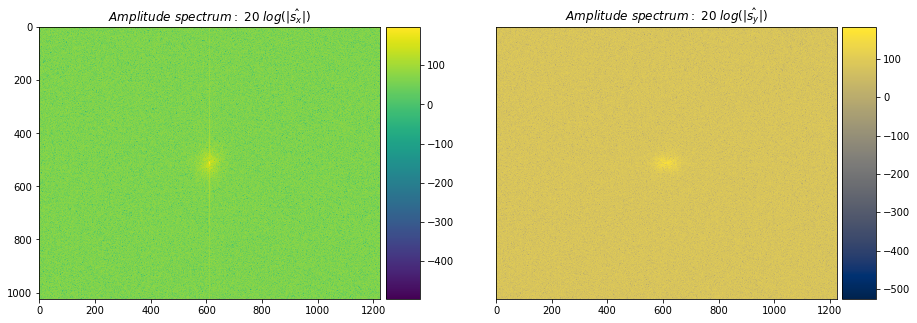

<Figure size 432x288 with 0 Axes>

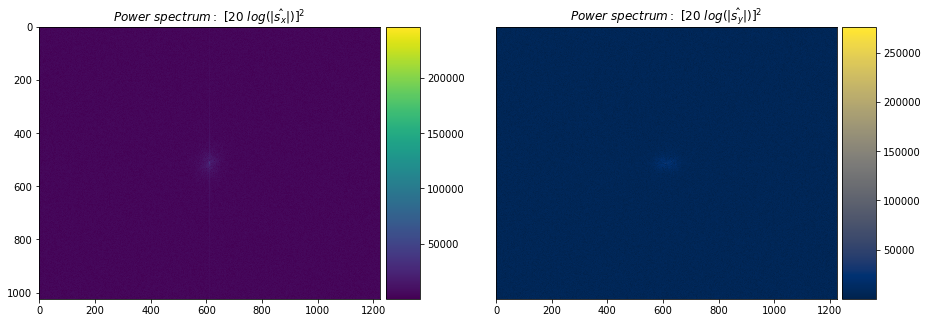

In [10]:
s_hat_x_noDC, s_hat_y_noDC = slopeFieldFFT(s_x - np.mean(s_x), s_y - np.mean(s_y))

When the input a is a time-domain signal and A = fft(a), np.abs(A) is its amplitude spectrum and np.abs(A)**2 is its power spectrum. The phase spectrum is obtained by np.angle(A).

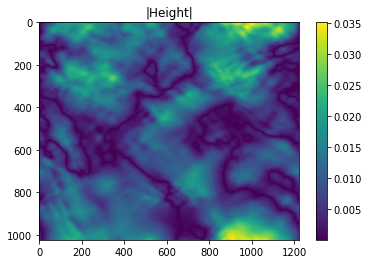

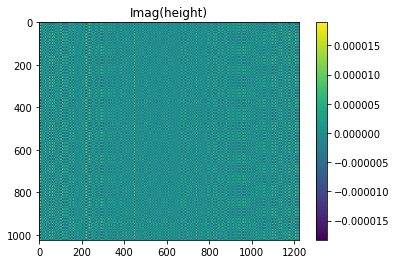

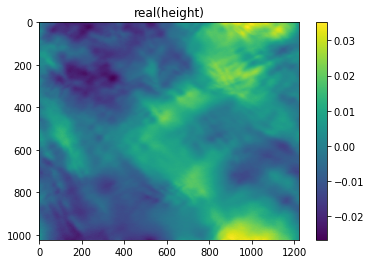

In [11]:
plt.figure()
plt.imshow(np.abs(height_map))
plt.colorbar()
plt.title('|Height|')
plt.show()

plt.figure()
plt.imshow(np.imag(height_map))
plt.colorbar()
plt.title('Imag(height)')
plt.show()

plt.figure()
plt.imshow(np.real(height_map))
plt.colorbar()
plt.title('real(height)')
plt.show()

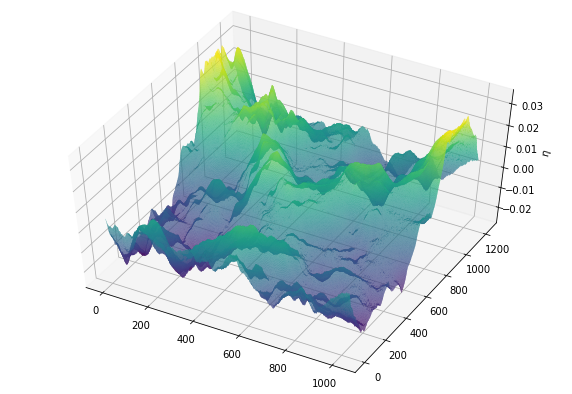

28.643600463867188


In [12]:
# %matplotlib widget
rows, cols = s_x.shape
Z = np.real(height_map)
X,Y = np.meshgrid(np.arange(0,cols), np.arange(0,rows))

fig = plt.figure(figsize = (10,7)) 
  
# syntax for 3-D plotting 
ax = plt.axes(projection ='3d') 

tic = time.time()
# syntax for plotting 
p = ax.plot_surface(Y, X, Z, cmap ='viridis', rstride = 2, cstride = 2)#, edgecolor ='green') 
# ax.set_title('Height map')
ax.set_zlabel('$\\eta$')
ax.view_init(azim = -61, elev = 52)
plt.show() 
toc = time.time()
print(toc-tic)

# SAVE the height, slope, raw data maps

In [13]:
all_height_maps = np.zeros((im_theta1.shape[0],im_theta1.shape[1],len(filenames)))
all_sx_maps = np.zeros((im_theta1.shape[0],im_theta1.shape[1],len(filenames)))
all_sy_maps = np.zeros((im_theta1.shape[0],im_theta1.shape[1],len(filenames)))
all_raw_frames_0filter = np.zeros((im_theta1.shape[0],im_theta1.shape[1],len(filenames)))

In [14]:
i=-1
cumul_height_map = np.zeros(im_theta1.shape, dtype = 'complex')
for filename2 in tqdm(filenames): #
    i+=1
    im_theta2, im_phi2 = theta_phi(filename2, file_location,
                               material = 'water',
                               flat_field_correct = 1,
                               gaussian_smoothing_sigma = 0,
                               num_images= NUM_IMAGES, correction_angle=0,
                               flat_field_correction_params = flat_field_correction_params)

    raw_img2 = cv2.imread(os.path.join(file_location, filename2))
    
    # get slopes and height maps
    s_x = np.tan(np.radians((im_theta2 - im_theta1)))
    s_y = np.tan(np.radians((im_phi2 - im_phi1)))
    s_hat_x, s_hat_y = slopeFieldFFT(s_x, s_y, suppress_fig = 1)
    height_map = slope2height(s_hat_x, s_hat_y)
    all_height_maps[:,:,i] = height_map
    all_sx_maps[:,:,i] = s_x
    all_sy_maps[:,:,i] = s_y
    all_raw_frames_0filter[:,:,i] = raw_img2[::2,::2,0]

  0%|                                                                                          | 0/226 [00:00<?, ?it/s]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03497958183288574 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04297471046447754 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.684455394744873 seconds
False
AoLP time:  0.04397249221801758 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  0%|▎                                                                               | 1/226 [00:25<1:37:24, 25.98s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03597831726074219 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.049993038177490234 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  27.767404317855835 seconds
False
AoLP time:  0.052968740463256836 s


  1%|▋                                                                               | 2/226 [00:55<1:40:24, 26.90s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0339810848236084 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04597735404968262 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.861550092697144 seconds
False
AoLP time:  0.05296754837036133 s


  1%|█                                                                               | 3/226 [01:18<1:36:20, 25.92s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0279848575592041 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03798246383666992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  25.993454456329346 seconds
False
AoLP time:  0.042973995208740234 s


  2%|█▍                                                                              | 4/226 [01:45<1:36:49, 26.17s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.030008554458618164 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04297494888305664 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.093415021896362 seconds
False
AoLP time:  0.056967973709106445 s


  2%|█▊                                                                              | 5/226 [02:09<1:33:52, 25.49s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.032979488372802734 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.052968502044677734 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.626312494277954 seconds
False
AoLP time:  0.044973134994506836 s


  3%|██                                                                              | 6/226 [02:32<1:31:11, 24.87s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03697824478149414 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.042975425720214844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.19422197341919 seconds
False
AoLP time:  0.04597282409667969 s


  3%|██▍                                                                             | 7/226 [02:55<1:28:41, 24.30s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.032979726791381836 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.05596566200256348 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.703541040420532 seconds
False
AoLP time:  0.04897022247314453 s


  4%|██▊                                                                             | 8/226 [03:19<1:27:27, 24.07s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03897714614868164 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.060469627380371094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.434462785720825 seconds
False
AoLP time:  0.04797029495239258 s


  4%|███▏                                                                            | 9/226 [03:42<1:26:10, 23.83s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.041975975036621094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04797029495239258 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.301624059677124 seconds
False
AoLP time:  0.041976213455200195 s


  4%|███▍                                                                           | 10/226 [04:05<1:24:57, 23.60s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03498077392578125 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.05096864700317383 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.17768144607544 seconds
False
AoLP time:  0.04996991157531738 s


  5%|███▊                                                                           | 11/226 [04:29<1:24:57, 23.71s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03298139572143555 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.041974544525146484 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.36788511276245 seconds
False
AoLP time:  0.04497027397155762 s


  5%|████▏                                                                          | 12/226 [04:52<1:23:57, 23.54s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03297924995422363 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04597306251525879 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.40326714515686 seconds
False
AoLP time:  0.04797077178955078 s


  6%|████▌                                                                          | 13/226 [05:15<1:23:10, 23.43s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.034978389739990234 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04297447204589844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.47055459022522 seconds
False
AoLP time:  0.054976463317871094 s


  6%|████▉                                                                          | 14/226 [05:39<1:22:36, 23.38s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03498220443725586 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04497361183166504 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.575058698654175 seconds
False
AoLP time:  0.04697227478027344 s


  7%|█████▏                                                                         | 15/226 [06:03<1:23:20, 23.70s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03098320960998535 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034979820251464844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.756849765777588 seconds
False
AoLP time:  0.04597210884094238 s


  7%|█████▌                                                                         | 16/226 [06:27<1:22:47, 23.65s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983665466308594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697824478149414 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.368074893951416 seconds
False
AoLP time:  0.03997611999511719 s


  8%|█████▉                                                                         | 17/226 [06:50<1:21:47, 23.48s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027984142303466797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897738456726074 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.545377254486084 seconds
False
AoLP time:  0.03997683525085449 s


  8%|██████▎                                                                        | 18/226 [07:13<1:21:09, 23.41s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028983354568481445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.038977861404418945 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.19119668006897 seconds
False
AoLP time:  0.04197525978088379 s


  8%|██████▋                                                                        | 19/226 [07:36<1:20:19, 23.28s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.030983448028564453 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.039975881576538086 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.517009019851685 seconds
False
AoLP time:  0.03997611999511719 s


  9%|██████▉                                                                        | 20/226 [07:59<1:19:56, 23.29s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02898406982421875 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897690773010254 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.284125328063965 seconds
False
AoLP time:  0.041974544525146484 s


  9%|███████▎                                                                       | 21/226 [08:22<1:19:18, 23.21s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984691619873047 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697776794433594 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.6339213848114 seconds
False
AoLP time:  0.04497337341308594 s


 10%|███████▋                                                                       | 22/226 [08:46<1:19:03, 23.25s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984214782714844 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697848320007324 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.81623911857605 seconds
False
AoLP time:  0.04397416114807129 s


 10%|████████                                                                       | 23/226 [09:10<1:20:12, 23.71s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028986215591430664 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997659683227539 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.635493278503418 seconds
False
AoLP time:  0.03897857666015625 s


 11%|████████▍                                                                      | 24/226 [09:35<1:20:29, 23.91s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982805252075195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034979820251464844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.341110229492188 seconds
False
AoLP time:  0.04097604751586914 s


 11%|████████▋                                                                      | 25/226 [09:58<1:19:14, 23.65s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02998065948486328 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04297518730163574 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.541975021362305 seconds
False
AoLP time:  0.039975881576538086 s


 12%|█████████                                                                      | 26/226 [10:21<1:18:27, 23.54s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982566833496094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497910499572754 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.456446409225464 seconds
False
AoLP time:  0.05296921730041504 s


 12%|█████████▍                                                                     | 27/226 [10:45<1:18:46, 23.75s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0319819450378418 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997635841369629 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.470016479492188 seconds
False
AoLP time:  0.040976524353027344 s


 12%|█████████▊                                                                     | 28/226 [11:09<1:17:49, 23.59s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027986764907836914 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03797793388366699 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.514991283416748 seconds
False
AoLP time:  0.03997468948364258 s


 13%|██████████▏                                                                    | 29/226 [11:32<1:17:04, 23.47s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983903884887695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036977529525756836 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.693888664245605 seconds
False
AoLP time:  0.0419766902923584 s


 13%|██████████▍                                                                    | 30/226 [11:55<1:16:36, 23.45s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035979270935058594 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.381085872650146 seconds
False
AoLP time:  0.04397320747375488 s


 14%|██████████▊                                                                    | 31/226 [12:18<1:15:53, 23.35s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027981281280517578 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035978078842163086 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.833826303482056 seconds
False
AoLP time:  0.041973114013671875 s


 14%|███████████▏                                                                   | 32/226 [12:42<1:15:43, 23.42s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0279843807220459 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697824478149414 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.33409571647644 seconds
False
AoLP time:  0.0399777889251709 s


 15%|███████████▌                                                                   | 33/226 [13:05<1:14:58, 23.31s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983903884887695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0359797477722168 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.67801856994629 seconds
False
AoLP time:  0.03997635841369629 s


 15%|███████████▉                                                                   | 34/226 [13:28<1:14:43, 23.35s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.030981779098510742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034980058670043945 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.422043323516846 seconds
False
AoLP time:  0.04397392272949219 s


 15%|████████████▏                                                                  | 35/226 [13:52<1:14:11, 23.30s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697800636291504 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.16119408607483 seconds
False
AoLP time:  0.04397416114807129 s


 16%|████████████▌                                                                  | 36/226 [14:14<1:13:24, 23.18s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028982877731323242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697776794433594 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.55596613883972 seconds
False
AoLP time:  0.04097700119018555 s


 16%|████████████▉                                                                  | 37/226 [14:38<1:13:04, 23.20s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982566833496094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697824478149414 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.61295223236084 seconds
False
AoLP time:  0.04397416114807129 s


 17%|█████████████▎                                                                 | 38/226 [15:01<1:12:46, 23.22s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0279848575592041 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597855567932129 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.938177824020386 seconds
False
AoLP time:  0.04297447204589844 s


 17%|█████████████▋                                                                 | 39/226 [15:25<1:12:49, 23.36s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02798748016357422 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597903251647949 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.84779691696167 seconds
False
AoLP time:  0.04097604751586914 s


 18%|█████████████▉                                                                 | 40/226 [15:48<1:12:35, 23.42s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027984619140625 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997659683227539 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.681913375854492 seconds
False
AoLP time:  0.03997445106506348 s


 18%|██████████████▎                                                                | 41/226 [16:12<1:12:10, 23.41s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.030981779098510742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03698015213012695 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.870803117752075 seconds
False
AoLP time:  0.03997516632080078 s


 19%|██████████████▋                                                                | 42/226 [16:35<1:11:55, 23.46s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028982162475585938 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897690773010254 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.597944498062134 seconds
False
AoLP time:  0.04097604751586914 s


 19%|███████████████                                                                | 43/226 [16:58<1:11:25, 23.42s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02998185157775879 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035979509353637695 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.414079427719116 seconds
False
AoLP time:  0.040975093841552734 s


 19%|███████████████▍                                                               | 44/226 [17:22<1:10:45, 23.33s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698373794555664 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034979820251464844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.350085973739624 seconds
False
AoLP time:  0.03897690773010254 s


 20%|███████████████▋                                                               | 45/226 [17:45<1:10:05, 23.24s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028984785079956055 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035978078842163086 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.508995532989502 seconds
False
AoLP time:  0.042974233627319336 s


 20%|████████████████                                                               | 46/226 [18:08<1:09:40, 23.22s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.031981468200683594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697657585144043 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.64891290664673 seconds
False
AoLP time:  0.04297304153442383 s


 21%|████████████████▍                                                              | 47/226 [18:31<1:09:27, 23.28s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698349952697754 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.037981510162353516 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.204169273376465 seconds
False
AoLP time:  0.041975975036621094 s


 21%|████████████████▊                                                              | 48/226 [18:54<1:08:47, 23.19s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698493003845215 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034981489181518555 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.193826913833618 seconds
False
AoLP time:  0.04097414016723633 s


 22%|█████████████████▏                                                             | 49/226 [19:17<1:08:09, 23.10s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028982877731323242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03797769546508789 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.777840852737427 seconds
False
AoLP time:  0.03997635841369629 s


 22%|█████████████████▍                                                             | 50/226 [19:41<1:08:08, 23.23s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027984142303466797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034978389739990234 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.46302103996277 seconds
False
AoLP time:  0.04597330093383789 s


 23%|█████████████████▊                                                             | 51/226 [20:04<1:07:42, 23.21s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027984619140625 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.039977073669433594 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.24015188217163 seconds
False
AoLP time:  0.04197573661804199 s


 23%|██████████████████▏                                                            | 52/226 [20:27<1:07:05, 23.14s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983976364135742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597736358642578 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.323102474212646 seconds
False
AoLP time:  0.037976980209350586 s


 23%|██████████████████▌                                                            | 53/226 [20:50<1:06:35, 23.10s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983665466308594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035977840423583984 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.34629535675049 seconds
False
AoLP time:  0.04197359085083008 s


 24%|██████████████████▉                                                            | 54/226 [21:13<1:06:09, 23.08s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698349952697754 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597879409790039 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.140225887298584 seconds
False
AoLP time:  0.04097700119018555 s


 24%|███████████████████▏                                                           | 55/226 [21:36<1:05:36, 23.02s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02998065948486328 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897714614868164 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.553969860076904 seconds
False
AoLP time:  0.04097557067871094 s


 25%|███████████████████▌                                                           | 56/226 [21:59<1:05:26, 23.10s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028983354568481445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697943687438965 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.09623384475708 seconds
False
AoLP time:  0.04097437858581543 s


 25%|███████████████████▉                                                           | 57/226 [22:22<1:04:51, 23.02s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982328414916992 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697681427001953 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.826810359954834 seconds
False
AoLP time:  0.04097604751586914 s


 26%|████████████████████▎                                                          | 58/226 [22:45<1:04:53, 23.18s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.031981706619262695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03797793388366699 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.531980991363525 seconds
False
AoLP time:  0.03997492790222168 s


 26%|████████████████████▌                                                          | 59/226 [23:09<1:04:36, 23.21s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982805252075195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.041975975036621094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.637990713119507 seconds
False
AoLP time:  0.0429692268371582 s


 27%|████████████████████▉                                                          | 60/226 [23:32<1:04:21, 23.26s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02798295021057129 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04097628593444824 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.531981945037842 seconds
False
AoLP time:  0.03897738456726074 s


 27%|█████████████████████▎                                                         | 61/226 [23:55<1:03:59, 23.27s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025983572006225586 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035977840423583984 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  25.08750319480896 seconds
False
AoLP time:  0.042974233627319336 s


 27%|█████████████████████▋                                                         | 62/226 [24:21<1:05:53, 24.11s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02898097038269043 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.033980369567871094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.231576919555664 seconds
False
AoLP time:  0.04097628593444824 s


 28%|██████████████████████                                                         | 63/226 [24:45<1:05:21, 24.06s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025986194610595703 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035980224609375 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.507994413375854 seconds
False
AoLP time:  0.04297471046447754 s


 28%|██████████████████████▎                                                        | 64/226 [25:09<1:04:18, 23.82s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027985334396362305 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036977291107177734 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.50232768058777 seconds
False
AoLP time:  0.04097580909729004 s


 29%|██████████████████████▋                                                        | 65/226 [25:32<1:03:24, 23.63s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0299832820892334 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.039975643157958984 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.243568181991577 seconds
False
AoLP time:  0.038977622985839844 s


 29%|███████████████████████                                                        | 66/226 [25:56<1:03:17, 23.74s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984214782714844 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03797769546508789 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.824811697006226 seconds
False
AoLP time:  0.049973249435424805 s


 30%|███████████████████████▍                                                       | 67/226 [26:19<1:02:43, 23.67s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983665466308594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497886657714844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.492002487182617 seconds
False
AoLP time:  0.03997659683227539 s


 30%|███████████████████████▊                                                       | 68/226 [26:42<1:01:59, 23.54s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028982877731323242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036978721618652344 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.887775897979736 seconds
False
AoLP time:  0.047971248626708984 s


 31%|████████████████████████                                                       | 69/226 [27:06<1:01:37, 23.55s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983665466308594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597855567932129 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.52287983894348 seconds
False
AoLP time:  0.04297375679016113 s


 31%|████████████████████████▍                                                      | 70/226 [27:29<1:01:01, 23.47s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025984764099121094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036978721618652344 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.924334287643433 seconds
False
AoLP time:  0.04097867012023926 s


 31%|████████████████████████▊                                                      | 71/226 [27:52<1:00:00, 23.23s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028983116149902344 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03297996520996094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.687889575958252 seconds
False
AoLP time:  0.040976524353027344 s


 32%|█████████████████████████▊                                                       | 72/226 [28:15<59:47, 23.29s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983976364135742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0399775505065918 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.451027631759644 seconds
False
AoLP time:  0.04097580909729004 s


 32%|██████████████████████████▏                                                      | 73/226 [28:39<59:17, 23.25s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.031981706619262695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997516632080078 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.554968118667603 seconds
False
AoLP time:  0.04197525978088379 s


 33%|██████████████████████████▌                                                      | 74/226 [29:02<58:55, 23.26s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698349952697754 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597855567932129 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.738874435424805 seconds
False
AoLP time:  0.04597282409667969 s


 33%|██████████████████████████▉                                                      | 75/226 [29:25<58:42, 23.33s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02898263931274414 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.032980918884277344 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.13420796394348 seconds
False
AoLP time:  0.04397463798522949 s


 34%|███████████████████████████▏                                                     | 76/226 [29:48<57:58, 23.19s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028982162475585938 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0359799861907959 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.567961931228638 seconds
False
AoLP time:  0.03997683525085449 s


 34%|███████████████████████████▌                                                     | 77/226 [30:12<57:39, 23.22s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983427047729492 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997683525085449 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.404053926467896 seconds
False
AoLP time:  0.04097437858581543 s


 35%|███████████████████████████▉                                                     | 78/226 [30:35<57:10, 23.18s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029981374740600586 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597879409790039 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.650508642196655 seconds
False
AoLP time:  0.0389559268951416 s


 35%|████████████████████████████▎                                                    | 79/226 [30:57<56:06, 22.90s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0299835205078125 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.65749979019165 seconds
False
AoLP time:  0.04397439956665039 s


 35%|████████████████████████████▋                                                    | 80/226 [31:19<55:16, 22.72s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984453201293945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098154067993164 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.740437984466553 seconds
False
AoLP time:  0.039975881576538086 s


 36%|█████████████████████████████                                                    | 81/226 [31:42<54:39, 22.62s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02998495101928711 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.066826343536377 seconds
False
AoLP time:  0.038971662521362305 s


 36%|█████████████████████████████▍                                                   | 82/226 [32:03<53:36, 22.34s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098130226135254 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.485604524612427 seconds
False
AoLP time:  0.038976430892944336 s


 37%|█████████████████████████████▋                                                   | 83/226 [32:25<53:04, 22.27s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398538589477539 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098011016845703 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.913336753845215 seconds
False
AoLP time:  0.037978172302246094 s


 37%|██████████████████████████████                                                   | 84/226 [32:48<52:52, 22.34s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698493003845215 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036978721618652344 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.444626569747925 seconds
False
AoLP time:  0.0399782657623291 s


 38%|██████████████████████████████▍                                                  | 85/226 [33:10<52:18, 22.26s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983976364135742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.028981924057006836 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.895875930786133 seconds
False
AoLP time:  0.03897738456726074 s


 38%|██████████████████████████████▊                                                  | 86/226 [33:33<52:12, 22.38s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398538589477539 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098297119140625 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.669477701187134 seconds
False
AoLP time:  0.03797793388366699 s


 38%|███████████████████████████████▏                                                 | 87/226 [33:55<51:45, 22.34s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398514747619629 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.031980276107788086 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.536574840545654 seconds
False
AoLP time:  0.03997611999511719 s


 39%|███████████████████████████████▌                                                 | 88/226 [34:17<51:14, 22.28s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02598428726196289 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0299837589263916 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.678492307662964 seconds
False
AoLP time:  0.03697824478149414 s


 39%|███████████████████████████████▉                                                 | 89/226 [34:39<50:57, 22.32s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983022689819336 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497886657714844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.012859344482422 seconds
False
AoLP time:  0.038977622985839844 s


 40%|████████████████████████████████▎                                                | 90/226 [35:01<50:11, 22.14s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0239865779876709 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.031981468200683594 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.21325135231018 seconds
False
AoLP time:  0.03898048400878906 s


 40%|████████████████████████████████▌                                                | 91/226 [35:23<49:37, 22.06s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022986650466918945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497910499572754 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.828964948654175 seconds
False
AoLP time:  0.04697275161743164 s


 41%|████████████████████████████████▉                                                | 92/226 [35:44<48:53, 21.89s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986339569091797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02898383140563965 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.717031478881836 seconds
False
AoLP time:  0.038974761962890625 s


 41%|█████████████████████████████████▎                                               | 93/226 [36:06<48:07, 21.71s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983427047729492 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02898383140563965 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.198753118515015 seconds
False
AoLP time:  0.03797721862792969 s


 42%|█████████████████████████████████▋                                               | 94/226 [36:28<47:49, 21.74s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398991584777832 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982328414916992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.052837371826172 seconds
False
AoLP time:  0.03897690773010254 s


 42%|██████████████████████████████████                                               | 95/226 [36:49<47:24, 21.71s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025984525680541992 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982328414916992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.86794376373291 seconds
False
AoLP time:  0.039975881576538086 s


 42%|██████████████████████████████████▍                                              | 96/226 [37:11<46:54, 21.65s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02298712730407715 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030982255935668945 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.767006635665894 seconds
False
AoLP time:  0.03897833824157715 s


 43%|██████████████████████████████████▊                                              | 97/226 [37:32<46:22, 21.57s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398681640625 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697919845581055 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.08281707763672 seconds
False
AoLP time:  0.03797769546508789 s


 43%|███████████████████████████████████                                              | 98/226 [37:54<46:06, 21.61s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986339569091797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982805252075195 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.95389461517334 seconds
False
AoLP time:  0.038976192474365234 s


 44%|███████████████████████████████████▍                                             | 99/226 [38:15<45:42, 21.60s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022986650466918945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0299832820892334 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.105805158615112 seconds
False
AoLP time:  0.03797602653503418 s


 44%|███████████████████████████████████▍                                            | 100/226 [38:37<45:26, 21.64s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030982017517089844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.862946271896362 seconds
False
AoLP time:  0.03898000717163086 s


 45%|███████████████████████████████████▊                                            | 101/226 [38:59<44:58, 21.59s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985074996948242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.033980369567871094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.066307306289673 seconds
False
AoLP time:  0.037976980209350586 s


 45%|████████████████████████████████████                                            | 102/226 [39:21<45:22, 21.96s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985790252685547 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982566833496094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.26171588897705 seconds
False
AoLP time:  0.04297685623168945 s


 46%|████████████████████████████████████▍                                           | 103/226 [39:43<45:00, 21.95s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02298736572265625 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02998208999633789 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.988873958587646 seconds
False
AoLP time:  0.038977622985839844 s


 46%|████████████████████████████████████▊                                           | 104/226 [40:05<44:26, 21.86s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597879409790039 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.915916681289673 seconds
False
AoLP time:  0.037976741790771484 s


 46%|█████████████████████████████████████▏                                          | 105/226 [40:27<43:54, 21.78s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698349952697754 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.032979488372802734 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.310688257217407 seconds
False
AoLP time:  0.03897690773010254 s


 47%|█████████████████████████████████████▌                                          | 106/226 [40:48<43:37, 21.82s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0339818000793457 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.236730337142944 seconds
False
AoLP time:  0.03997683525085449 s


 47%|█████████████████████████████████████▉                                          | 107/226 [41:10<43:20, 21.85s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698349952697754 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.032979488372802734 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.00744080543518 seconds
False
AoLP time:  0.03896594047546387 s


 48%|██████████████████████████████████████▏                                         | 108/226 [41:32<42:51, 21.79s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022986888885498047 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.028983592987060547 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.96388840675354 seconds
False
AoLP time:  0.03897666931152344 s


 48%|██████████████████████████████████████▌                                         | 109/226 [41:54<42:23, 21.74s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023983001708984375 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597855567932129 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.89592671394348 seconds
False
AoLP time:  0.04197382926940918 s


 49%|██████████████████████████████████████▉                                         | 110/226 [42:15<41:53, 21.66s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025984764099121094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030982017517089844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.79298686981201 seconds
False
AoLP time:  0.038977622985839844 s


 49%|███████████████████████████████████████▎                                        | 111/226 [42:37<41:22, 21.59s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022986888885498047 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03198075294494629 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.705766677856445 seconds
False
AoLP time:  0.04097557067871094 s


 50%|███████████████████████████████████████▋                                        | 112/226 [42:59<41:27, 21.82s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985790252685547 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.038977861404418945 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.85090184211731 seconds
False
AoLP time:  0.040969133377075195 s


 50%|████████████████████████████████████████                                        | 113/226 [43:21<41:30, 22.04s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034980058670043945 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.143784761428833 seconds
False
AoLP time:  0.03997635841369629 s


 50%|████████████████████████████████████████▎                                       | 114/226 [43:43<40:58, 21.96s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02498483657836914 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098154067993164 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.297695875167847 seconds
False
AoLP time:  0.037975311279296875 s


 51%|████████████████████████████████████████▋                                       | 115/226 [44:05<40:37, 21.96s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023984432220458984 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697824478149414 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.368654251098633 seconds
False
AoLP time:  0.04397416114807129 s


 51%|█████████████████████████████████████████                                       | 116/226 [44:27<40:17, 21.97s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497958183288574 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.343669176101685 seconds
False
AoLP time:  0.03897833824157715 s


 52%|█████████████████████████████████████████▍                                      | 117/226 [44:49<39:56, 21.99s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0259854793548584 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03398013114929199 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.277705907821655 seconds
False
AoLP time:  0.038974761962890625 s


 52%|█████████████████████████████████████████▊                                      | 118/226 [45:11<39:33, 21.97s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0339808464050293 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.70293140411377 seconds
False
AoLP time:  0.03797602653503418 s


 53%|██████████████████████████████████████████                                      | 119/226 [45:34<39:22, 22.08s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985002517700195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034979820251464844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.141785860061646 seconds
False
AoLP time:  0.03997516632080078 s


 53%|██████████████████████████████████████████▍                                     | 120/226 [45:55<38:51, 21.99s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03198075294494629 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.333672285079956 seconds
False
AoLP time:  0.04497265815734863 s


 54%|██████████████████████████████████████████▊                                     | 121/226 [46:17<38:31, 22.01s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098154067993164 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.281704902648926 seconds
False
AoLP time:  0.039977312088012695 s


 54%|███████████████████████████████████████████▏                                    | 122/226 [46:39<38:06, 21.99s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022986650466918945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036978721618652344 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.52856159210205 seconds
False
AoLP time:  0.03897833824157715 s


 54%|███████████████████████████████████████████▌                                    | 123/226 [47:01<37:50, 22.05s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697824478149414 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.31121826171875 seconds
False
AoLP time:  0.04397416114807129 s


 55%|███████████████████████████████████████████▉                                    | 124/226 [47:23<37:24, 22.01s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03297996520996094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.37664818763733 seconds
False
AoLP time:  0.05097031593322754 s


 55%|████████████████████████████████████████████▏                                   | 125/226 [47:45<37:03, 22.02s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.031980276107788086 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.38364601135254 seconds
False
AoLP time:  0.038976430892944336 s


 56%|████████████████████████████████████████████▌                                   | 126/226 [48:07<36:41, 22.01s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983665466308594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497886657714844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.058833837509155 seconds
False
AoLP time:  0.04197359085083008 s


 56%|████████████████████████████████████████████▉                                   | 127/226 [48:29<36:08, 21.91s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985313415527344 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098154067993164 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.246726036071777 seconds
False
AoLP time:  0.03897714614868164 s


 57%|█████████████████████████████████████████████▎                                  | 128/226 [48:51<35:46, 21.90s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985624313354492 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.032979726791381836 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.90192413330078 seconds
False
AoLP time:  0.03897714614868164 s


 57%|█████████████████████████████████████████████▋                                  | 129/226 [49:13<35:13, 21.79s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398395538330078 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.028983592987060547 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.175286054611206 seconds
False
AoLP time:  0.039975881576538086 s


 58%|██████████████████████████████████████████████                                  | 130/226 [49:34<34:51, 21.79s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024983644485473633 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030983448028564453 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.996885299682617 seconds
False
AoLP time:  0.03897690773010254 s


 58%|██████████████████████████████████████████████▎                                 | 131/226 [49:56<34:26, 21.76s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02998208999633789 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.178762674331665 seconds
False
AoLP time:  0.03997540473937988 s


 58%|██████████████████████████████████████████████▋                                 | 132/226 [50:18<34:07, 21.79s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02498483657836914 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02998185157775879 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.07482409477234 seconds
False
AoLP time:  0.03797006607055664 s


 59%|███████████████████████████████████████████████                                 | 133/226 [50:40<33:42, 21.75s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024984359741210938 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030980348587036133 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.268711805343628 seconds
False
AoLP time:  0.0379796028137207 s


 59%|███████████████████████████████████████████████▍                                | 134/226 [51:01<33:24, 21.79s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025986194610595703 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497958183288574 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.205840826034546 seconds
False
AoLP time:  0.03797602653503418 s


 60%|███████████████████████████████████████████████▊                                | 135/226 [51:23<33:04, 21.81s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984453201293945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02898263931274414 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.762003183364868 seconds
False
AoLP time:  0.0379786491394043 s


 60%|████████████████████████████████████████████████▏                               | 136/226 [51:45<32:31, 21.68s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398848533630371 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098297119140625 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.67105793952942 seconds
False
AoLP time:  0.03898000717163086 s


 61%|████████████████████████████████████████████████▍                               | 137/226 [52:06<31:59, 21.56s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0239870548248291 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03198075294494629 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.79598569869995 seconds
False
AoLP time:  0.03697633743286133 s


 61%|████████████████████████████████████████████████▊                               | 138/226 [52:27<31:33, 21.52s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698349952697754 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697824478149414 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.01585817337036 seconds
False
AoLP time:  0.03997659683227539 s


 62%|█████████████████████████████████████████████████▏                              | 139/226 [52:49<31:14, 21.55s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03198051452636719 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.914916038513184 seconds
False
AoLP time:  0.038974761962890625 s


 62%|█████████████████████████████████████████████████▌                              | 140/226 [53:11<30:53, 21.55s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025984525680541992 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982566833496094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.060343503952026 seconds
False
AoLP time:  0.03897523880004883 s


 62%|█████████████████████████████████████████████████▉                              | 141/226 [53:32<30:34, 21.58s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0239865779876709 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497934341430664 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.737019777297974 seconds
False
AoLP time:  0.03797507286071777 s


 63%|██████████████████████████████████████████████████▎                             | 142/226 [53:54<30:06, 21.51s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497910499572754 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.64149808883667 seconds
False
AoLP time:  0.040975332260131836 s


 63%|██████████████████████████████████████████████████▌                             | 143/226 [54:16<30:06, 21.77s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02498459815979004 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029983997344970703 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.440612077713013 seconds
False
AoLP time:  0.03797793388366699 s


 64%|██████████████████████████████████████████████████▉                             | 144/226 [54:38<29:52, 21.86s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024983882904052734 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982566833496094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.85595202445984 seconds
False
AoLP time:  0.03897690773010254 s


 64%|███████████████████████████████████████████████████▎                            | 145/226 [54:59<29:22, 21.76s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098320960998535 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.60003662109375 seconds
False
AoLP time:  0.037970781326293945 s


 65%|███████████████████████████████████████████████████▋                            | 146/226 [55:22<29:13, 21.91s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022984981536865234 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03297877311706543 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.15977454185486 seconds
False
AoLP time:  0.038979291915893555 s


 65%|████████████████████████████████████████████████████                            | 147/226 [55:44<28:50, 21.90s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985002517700195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697800636291504 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.76700210571289 seconds
False
AoLP time:  0.03797578811645508 s


 65%|████████████████████████████████████████████████████▍                           | 148/226 [56:05<28:16, 21.75s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398681640625 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03298068046569824 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.960890293121338 seconds
False
AoLP time:  0.03897714614868164 s


 66%|████████████████████████████████████████████████████▋                           | 149/226 [56:27<27:50, 21.69s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03198099136352539 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.92790937423706 seconds
False
AoLP time:  0.03797435760498047 s


 66%|█████████████████████████████████████████████████████                           | 150/226 [56:48<27:25, 21.65s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986339569091797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098320960998535 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.92291235923767 seconds
False
AoLP time:  0.037975311279296875 s


 67%|█████████████████████████████████████████████████████▍                          | 151/226 [57:10<27:01, 21.62s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023984909057617188 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03797793388366699 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.09371280670166 seconds
False
AoLP time:  0.03897881507873535 s


 67%|█████████████████████████████████████████████████████▊                          | 152/226 [57:31<26:42, 21.66s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983903884887695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.028983592987060547 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.073824882507324 seconds
False
AoLP time:  0.036978960037231445 s


 68%|██████████████████████████████████████████████████████▏                         | 153/226 [57:53<26:21, 21.67s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982328414916992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.37166476249695 seconds
False
AoLP time:  0.038974761962890625 s


 68%|██████████████████████████████████████████████████████▌                         | 154/226 [58:15<26:07, 21.77s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02498459815979004 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.033980369567871094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.859949111938477 seconds
False
AoLP time:  0.0379788875579834 s


 69%|██████████████████████████████████████████████████████▊                         | 155/226 [58:37<25:39, 21.69s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035979270935058594 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.806978702545166 seconds
False
AoLP time:  0.03797626495361328 s


 69%|███████████████████████████████████████████████████████▏                        | 156/226 [58:58<25:12, 21.61s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984214782714844 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982328414916992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.884984493255615 seconds
False
AoLP time:  0.03797578811645508 s


 69%|███████████████████████████████████████████████████████▌                        | 157/226 [59:20<24:48, 21.57s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03298068046569824 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.08881688117981 seconds
False
AoLP time:  0.039977073669433594 s


 70%|███████████████████████████████████████████████████████▉                        | 158/226 [59:41<24:29, 21.62s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023984670639038086 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03298044204711914 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.073824644088745 seconds
False
AoLP time:  0.03697848320007324 s


 70%|██████████████████████████████████████████████████████▉                       | 159/226 [1:00:03<24:10, 21.65s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02598428726196289 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982328414916992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.416626691818237 seconds
False
AoLP time:  0.038974761962890625 s


 71%|███████████████████████████████████████████████████████▏                      | 160/226 [1:00:25<23:57, 21.78s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024981260299682617 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030981779098510742 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.492581367492676 seconds
False
AoLP time:  0.03997683525085449 s


 71%|███████████████████████████████████████████████████████▌                      | 161/226 [1:00:47<23:42, 21.88s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02498459815979004 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.031981706619262695 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.44161033630371 seconds
False
AoLP time:  0.03798174858093262 s


 72%|███████████████████████████████████████████████████████▉                      | 162/226 [1:01:09<23:23, 21.93s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984453201293945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982566833496094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.78205895423889 seconds
False
AoLP time:  0.039974212646484375 s


 72%|████████████████████████████████████████████████████████▎                     | 163/226 [1:01:31<22:52, 21.78s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02898406982421875 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.960888624191284 seconds
False
AoLP time:  0.03897666931152344 s


 73%|████████████████████████████████████████████████████████▌                     | 164/226 [1:01:52<22:26, 21.72s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03297853469848633 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.772998571395874 seconds
False
AoLP time:  0.03797745704650879 s


 73%|████████████████████████████████████████████████████████▉                     | 165/226 [1:02:14<21:59, 21.63s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02498602867126465 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02898240089416504 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.897927045822144 seconds
False
AoLP time:  0.03897666931152344 s


 73%|█████████████████████████████████████████████████████████▎                    | 166/226 [1:02:35<21:35, 21.59s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030981779098510742 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.104807376861572 seconds
False
AoLP time:  0.03897833824157715 s


 74%|█████████████████████████████████████████████████████████▋                    | 167/226 [1:02:57<21:16, 21.63s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986339569091797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982566833496094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.974946975708008 seconds
False
AoLP time:  0.03897666931152344 s


 74%|█████████████████████████████████████████████████████████▉                    | 168/226 [1:03:18<20:54, 21.63s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0339808464050293 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.911917686462402 seconds
False
AoLP time:  0.03896594047546387 s


 75%|██████████████████████████████████████████████████████████▎                   | 169/226 [1:03:40<20:30, 21.59s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030981779098510742 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.733022212982178 seconds
False
AoLP time:  0.03897500038146973 s


 75%|██████████████████████████████████████████████████████████▋                   | 170/226 [1:04:01<20:05, 21.53s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984453201293945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982805252075195 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.970884799957275 seconds
False
AoLP time:  0.03997683525085449 s


 76%|███████████████████████████████████████████████████████████                   | 171/226 [1:04:23<19:45, 21.55s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025980472564697266 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0359799861907959 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.62208652496338 seconds
False
AoLP time:  0.03897523880004883 s


 76%|███████████████████████████████████████████████████████████▎                  | 172/226 [1:04:44<19:19, 21.47s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023984670639038086 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.032982826232910156 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.249723434448242 seconds
False
AoLP time:  0.03697776794433594 s


 77%|███████████████████████████████████████████████████████████▋                  | 173/226 [1:05:06<19:05, 21.61s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029983997344970703 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.893418073654175 seconds
False
AoLP time:  0.03897452354431152 s


 77%|████████████████████████████████████████████████████████████                  | 174/226 [1:05:28<18:42, 21.59s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025986194610595703 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697919845581055 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.068827629089355 seconds
False
AoLP time:  0.0399777889251709 s


 77%|████████████████████████████████████████████████████████████▍                 | 175/226 [1:05:49<18:22, 21.62s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983665466308594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.028981447219848633 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.134788751602173 seconds
False
AoLP time:  0.03797769546508789 s


 78%|████████████████████████████████████████████████████████████▋                 | 176/226 [1:06:11<18:03, 21.66s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.028982877731323242 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.50457525253296 seconds
False
AoLP time:  0.038977861404418945 s


 78%|█████████████████████████████████████████████████████████████                 | 177/226 [1:06:33<17:48, 21.81s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0259854793548584 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497958183288574 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.911916971206665 seconds
False
AoLP time:  0.039974212646484375 s


 79%|█████████████████████████████████████████████████████████████▍                | 178/226 [1:06:55<17:23, 21.74s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025984764099121094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030981779098510742 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.77002716064453 seconds
False
AoLP time:  0.0379796028137207 s


 79%|█████████████████████████████████████████████████████████████▊                | 179/226 [1:07:16<16:58, 21.68s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985624313354492 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697848320007324 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.42562198638916 seconds
False
AoLP time:  0.03797578811645508 s


 80%|██████████████████████████████████████████████████████████████                | 180/226 [1:07:39<16:42, 21.80s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022986888885498047 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03198122978210449 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.947896480560303 seconds
False
AoLP time:  0.038976430892944336 s


 80%|██████████████████████████████████████████████████████████████▍               | 181/226 [1:08:00<16:17, 21.73s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398514747619629 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597879409790039 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.98287796974182 seconds
False
AoLP time:  0.03897690773010254 s


 81%|██████████████████████████████████████████████████████████████▊               | 182/226 [1:08:22<15:54, 21.70s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024983882904052734 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030982017517089844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.964886903762817 seconds
False
AoLP time:  0.037978172302246094 s


 81%|███████████████████████████████████████████████████████████████▏              | 183/226 [1:08:43<15:31, 21.67s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983976364135742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030981063842773438 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.834962844848633 seconds
False
AoLP time:  0.03897523880004883 s


 81%|███████████████████████████████████████████████████████████████▌              | 184/226 [1:09:05<15:07, 21.61s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023984909057617188 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.032980918884277344 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.945366144180298 seconds
False
AoLP time:  0.039975643157958984 s


 82%|███████████████████████████████████████████████████████████████▊              | 185/226 [1:09:27<14:58, 21.92s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022986650466918945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029983043670654297 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.48258638381958 seconds
False
AoLP time:  0.040976524353027344 s


 82%|████████████████████████████████████████████████████████████████▏             | 186/226 [1:09:50<14:39, 21.98s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0259857177734375 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03397989273071289 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.346667766571045 seconds
False
AoLP time:  0.03797507286071777 s


 83%|████████████████████████████████████████████████████████████████▌             | 187/226 [1:10:12<14:16, 21.97s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986339569091797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029981374740600586 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.822967052459717 seconds
False
AoLP time:  0.03897714614868164 s


 83%|████████████████████████████████████████████████████████████████▉             | 188/226 [1:10:33<13:48, 21.81s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026985645294189453 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03298044204711914 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.97588062286377 seconds
False
AoLP time:  0.03797721862792969 s


 84%|█████████████████████████████████████████████████████████████████▏            | 189/226 [1:10:55<13:25, 21.77s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985551834106445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982328414916992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.289241790771484 seconds
False
AoLP time:  0.03897714614868164 s


 84%|█████████████████████████████████████████████████████████████████▌            | 190/226 [1:11:17<13:05, 21.83s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0259854793548584 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03298068046569824 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.967884302139282 seconds
False
AoLP time:  0.03897714614868164 s


 85%|█████████████████████████████████████████████████████████████████▉            | 191/226 [1:11:38<12:41, 21.74s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982328414916992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.88693332672119 seconds
False
AoLP time:  0.037976980209350586 s


 85%|██████████████████████████████████████████████████████████████████▎           | 192/226 [1:12:00<12:16, 21.67s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984453201293945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030983924865722656 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.719029903411865 seconds
False
AoLP time:  0.03897690773010254 s


 85%|██████████████████████████████████████████████████████████████████▌           | 193/226 [1:12:21<11:51, 21.56s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025984764099121094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.031980037689208984 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.09481167793274 seconds
False
AoLP time:  0.0399777889251709 s


 86%|██████████████████████████████████████████████████████████████████▉           | 194/226 [1:12:43<11:32, 21.64s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023984909057617188 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.032981157302856445 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.6780526638031 seconds
False
AoLP time:  0.037976980209350586 s


 86%|███████████████████████████████████████████████████████████████████▎          | 195/226 [1:13:04<11:07, 21.53s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0299837589263916 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.198299884796143 seconds
False
AoLP time:  0.03797769546508789 s


 87%|███████████████████████████████████████████████████████████████████▋          | 196/226 [1:13:26<10:48, 21.62s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02598404884338379 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02898263931274414 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.703039407730103 seconds
False
AoLP time:  0.04197359085083008 s


 87%|███████████████████████████████████████████████████████████████████▉          | 197/226 [1:13:47<10:25, 21.55s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985790252685547 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.028982162475585938 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.67005705833435 seconds
False
AoLP time:  0.03897690773010254 s


 88%|████████████████████████████████████████████████████████████████████▎         | 198/226 [1:14:09<10:01, 21.49s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984691619873047 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982566833496094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.855947732925415 seconds
False
AoLP time:  0.03997468948364258 s


 88%|████████████████████████████████████████████████████████████████████▋         | 199/226 [1:14:30<09:40, 21.49s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985074996948242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.02898240089416504 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.01485776901245 seconds
False
AoLP time:  0.03897833824157715 s


 88%|█████████████████████████████████████████████████████████████████████         | 200/226 [1:14:52<09:19, 21.53s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02298426628112793 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03198122978210449 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.033846855163574 seconds
False
AoLP time:  0.03997683525085449 s


 89%|█████████████████████████████████████████████████████████████████████▎        | 201/226 [1:15:13<08:58, 21.55s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983665466308594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597879409790039 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.18678855895996 seconds
False
AoLP time:  0.03797626495361328 s


 89%|█████████████████████████████████████████████████████████████████████▋        | 202/226 [1:15:35<08:39, 21.63s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984214782714844 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597855567932129 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.724449396133423 seconds
False
AoLP time:  0.03697943687438965 s


 90%|██████████████████████████████████████████████████████████████████████        | 203/226 [1:15:58<08:22, 21.86s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985074996948242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597855567932129 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.291699409484863 seconds
False
AoLP time:  0.038968801498413086 s


 90%|██████████████████████████████████████████████████████████████████████▍       | 204/226 [1:16:19<08:01, 21.87s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03298187255859375 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.322681665420532 seconds
False
AoLP time:  0.03897690773010254 s


 91%|██████████████████████████████████████████████████████████████████████▊       | 205/226 [1:16:41<07:39, 21.88s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026986122131347656 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030982494354248047 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.5075740814209 seconds
False
AoLP time:  0.03897857666015625 s


 91%|███████████████████████████████████████████████████████████████████████       | 206/226 [1:17:03<07:19, 21.95s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.022986650466918945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029983043670654297 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.18430209159851 seconds
False
AoLP time:  0.03897500038146973 s


 92%|███████████████████████████████████████████████████████████████████████▍      | 207/226 [1:17:25<06:56, 21.90s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0259859561920166 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036977529525756836 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.6950421333313 seconds
False
AoLP time:  0.03897714614868164 s


 92%|███████████████████████████████████████████████████████████████████████▊      | 208/226 [1:17:47<06:31, 21.74s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023984909057617188 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982328414916992 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.91191864013672 seconds
False
AoLP time:  0.03797006607055664 s


 92%|████████████████████████████████████████████████████████████████████████▏     | 209/226 [1:18:08<06:08, 21.67s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02398538589477539 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029982566833496094 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.02085566520691 seconds
False
AoLP time:  0.037978410720825195 s


 93%|████████████████████████████████████████████████████████████████████████▍     | 210/226 [1:18:30<05:46, 21.66s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985790252685547 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.029983043670654297 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.017857313156128 seconds
False
AoLP time:  0.03897881507873535 s


 93%|████████████████████████████████████████████████████████████████████████▊     | 211/226 [1:18:51<05:24, 21.65s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985240936279297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03397989273071289 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.863367319107056 seconds
False
AoLP time:  0.046971797943115234 s


 94%|█████████████████████████████████████████████████████████████████████████▏    | 212/226 [1:19:14<05:07, 21.94s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03398013114929199 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.038977861404418945 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.916667461395264 seconds
False
AoLP time:  0.041977643966674805 s


 94%|█████████████████████████████████████████████████████████████████████████▌    | 213/226 [1:19:39<04:57, 22.88s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0339808464050293 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.91291856765747 seconds
False
AoLP time:  0.03997683525085449 s


 95%|█████████████████████████████████████████████████████████████████████████▊    | 214/226 [1:20:01<04:29, 22.49s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983976364135742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030980348587036133 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  21.81739568710327 seconds
False
AoLP time:  0.04097795486450195 s


 95%|██████████████████████████████████████████████████████████████████████████▏   | 215/226 [1:20:23<04:07, 22.49s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023987293243408203 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03397965431213379 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.970884323120117 seconds
False
AoLP time:  0.039975643157958984 s


 96%|██████████████████████████████████████████████████████████████████████████▌   | 216/226 [1:20:45<03:42, 22.22s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025983810424804688 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.033980607986450195 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  20.983876705169678 seconds
False
AoLP time:  0.04197573661804199 s


 96%|██████████████████████████████████████████████████████████████████████████▉   | 217/226 [1:21:06<03:18, 22.04s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02498483657836914 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.033978939056396484 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.170213222503662 seconds
False
AoLP time:  0.03897690773010254 s


 96%|███████████████████████████████████████████████████████████████████████████▏  | 218/226 [1:21:29<02:58, 22.29s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984214782714844 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03298068046569824 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  23.051681995391846 seconds
False
AoLP time:  0.03997492790222168 s


 97%|███████████████████████████████████████████████████████████████████████████▌  | 219/226 [1:21:53<02:38, 22.71s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985074996948242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030983924865722656 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  24.463866233825684 seconds
False
AoLP time:  0.040973663330078125 s


 97%|███████████████████████████████████████████████████████████████████████████▉  | 220/226 [1:22:18<02:20, 23.43s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.031980276107788086 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  24.49884557723999 seconds
False
AoLP time:  0.03997397422790527 s


 98%|████████████████████████████████████████████████████████████████████████████▎ | 221/226 [1:22:43<01:59, 23.96s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0259859561920166 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030982017517089844 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  24.260000944137573 seconds
False
AoLP time:  0.0399782657623291 s


 98%|████████████████████████████████████████████████████████████████████████████▌ | 222/226 [1:23:08<01:37, 24.25s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023983240127563477 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0319821834564209 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  24.0970778465271 seconds
False
AoLP time:  0.040978193283081055 s


 99%|████████████████████████████████████████████████████████████████████████████▉ | 223/226 [1:23:33<01:13, 24.41s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983665466308594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03198075294494629 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  24.007148265838623 seconds
False
AoLP time:  0.03997397422790527 s


 99%|█████████████████████████████████████████████████████████████████████████████▎| 224/226 [1:23:58<00:48, 24.49s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985002517700195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697800636291504 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.712876319885254 seconds
False
AoLP time:  0.04297447204589844 s


100%|█████████████████████████████████████████████████████████████████████████████▋| 225/226 [1:24:21<00:24, 24.17s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985624313354492 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03498077392578125 s
im_DOLP shape is :  (1024, 1224)
Time for DOLP2Theta conversion is :  22.560965538024902 seconds
False
AoLP time:  0.04996848106384277 s


100%|██████████████████████████████████████████████████████████████████████████████| 226/226 [1:24:44<00:00, 23.94s/it]


In [15]:
del im_theta1, im_theta2, s_x, s_y, s_hat_x, s_hat_y

In [16]:
all_data_dict = {'all_height_maps': all_height_maps, 'all_sx_maps': all_sx_maps, \
                 'all_sy_maps':all_sy_maps, 'all_raw_frames_0filter':all_raw_frames_0filter}

Save using Klepto -- not pickle : directly to disk -- not memory intensive

In [17]:
# tic = time.time()
# with open(os.path.join(save_location,data_filename), 'wb') as handle:
#     pickle.dump(all_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print('time taken = ', time.time() - tic)

In [18]:
tic = time.time()
demo = dir_archive(os.path.join(save_location, data_foldername), {}, \
                   serialized=True, cached=False)

demo['all_height_maps'] = all_height_maps
toc = time.time()
print('time taken = ', toc - tic)

demo['all_sx_maps'] = all_sx_maps
toc = time.time()
print('time taken = ', toc - tic)

demo['all_sy_maps'] = all_sy_maps
toc = time.time()
print('time taken = ', toc - tic)

demo['all_raw_frames_0filter'] = all_raw_frames_0filter
toc = time.time()
print('time taken = ', toc - tic)

time taken =  8.407643795013428
time taken =  15.66366696357727
time taken =  22.754902839660645
time taken =  30.18752145767212


In [25]:
demo.dump()

In [20]:
# for k in all_data_dict_loaded.keys():
#     print(all_data_dict_loaded[k].all() == all_data_dict[k].all())

In [21]:
# time_mean_height_map = cumul_height_map/len(filenames)

## Plot the manually generated facets - Algebraic method

In [22]:
# import numpy as np

# def rotationX(alpha):
#     temp  = [[1, 0, 0],\
#              [0, np.cos(alpha), -np.sin(alpha)],
#              [0, np.sin(alpha), np.cos(alpha)]]
#     return temp

# def rotationY(alpha):
#     temp  = [[np.cos(alpha), 0, np.sin(alpha)],\
#              [0, 1, 0],
#              [-np.sin(alpha), 0, np.cos(alpha)]]
#     return temp

# rows, cols = im_theta1.shape

# x = np.arange(0, cols)
# y = np.arange(0, rows)

# X, Y = np.meshgrid(x,y)
# Z = np.zeros((rows,cols)) # Z = 0 at node (0,0)


# # parameters of the any plane facet that need to keeo updating
# nx = np.zeros((rows,cols))
# ny = np.zeros((rows,cols))
# nz = np.zeros((rows,cols))

# visited = np.zeros((rows,cols))
# d = np.zeros((rows,cols))
# visited[0,0]  = 1

# # evaluate the normals nx, ny, nz
# delta_theta = np.radians(im_theta2 - im_theta1)
# delta_phi = np.radians(im_phi2 - im_phi1)
# for i in tqdm(range(rows)):
#     for j in range(cols):
#         temp = rotationX(delta_theta[i,j]) @ np.array([0,0,1]).reshape(3,1)
#         nx[i,j] = temp[0]

#         temp = rotationY(delta_phi[i,j]) @ np.array([0,0,1]).reshape(3,1)
#         ny[i,j] = temp[0]

# nz = np.sqrt(1 - nx**2 - ny**2)
# assert nz.shape == im_theta1.shape

In [23]:
# for i in tqdm(range(rows)):
#     for j in range(cols):
#         if i==0 and j!=0: # Z = 0 at node (0,0)
#             Z[i,j] = -d[i,j-1] - nx[i,j-1]*X[i,j] - ny[i,j-1]*Y[i,j]
#             Z[i,j]/= nz[i,j-1]
#         elif i!=0 and j==0:
#             Z[i,j] = -d[i-1,j] - nx[i-1,j]*X[i,j] - ny[i-1,j]*Y[i,j]
#             Z[i,j]/= nz[i-1,j]
#         elif i!=0 and j!=0:
#             Z_north= -d[i-1,j] - nx[i-1,j]*X[i,j] - ny[i-1,j]*Y[i,j]
#             Z_north/= nz[i-1,j]
            
#             Z_west = -d[i,j-1] - nx[i,j-1]*X[i,j] - ny[i,j-1]*Y[i,j]
#             Z_west/= nz[i,j-1]
            
#             Z_diag = -d[i-1,j-1] - nx[i-1,j-1]*X[i,j] - ny[i-1,j-1]*Y[i,j]
#             Z_diag/= nz[i-1,j-1]

#             Z[i,j] = np.mean([Z_west, Z_north, Z_diag])
#         d[i,j] = -nx[i,j]*X[i,j]- ny[i,j]*Y[i,j] - nz[i,j]*Z[i,j]
#         visited[i,j] = 1


In [24]:
# plt.imshow(Z)
# plt.colorbar()